In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras import layers, models, optimizers
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier, KerasRegressor
import scikeras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('Interview_analysis_final.csv')
df = data.copy()

In [3]:
df.head()

,Date,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss,home,away,series result,cumulative wins,cumulative losses
0,2020-10-11,9,0.666667,0.777778,0,1,1,1,0,0,1,1,4,2
1,2020-10-09,8,0.250000,0.250000,0,1,-1,0,1,0,1,0,3,2
2,2020-10-08,10,0.600000,0.800000,1,0,0,0,0,0,1,0,3,1
3,2020-10-06,11,0.727273,0.909091,0,1,1,1,0,0,1,0,3,1
4,2020-10-05,9,0.222222,0.777778,1,0,0,0,0,0,1,0,2,1


### As Lebron's response rating is contained in [0,1] we will be classifying his tone as either 'more neutral' or 'more positive'. Here 'more positive' corresponds to all interviews with a response rating greater than 0.5 and 'more neutral' corresponds to the rest.

In [4]:
response_np = []
for ele in df['Responses rating']:
    if ele > 0.5:
        response_np.append(1)
    else:
        response_np.append(0)

In [5]:
df['Response classification'] = response_np
df.head()

,Date,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss,home,away,series result,cumulative wins,cumulative losses,Response classification
0,2020-10-11,9,0.666667,0.777778,0,1,1,1,0,0,1,1,4,2,1
1,2020-10-09,8,0.250000,0.250000,0,1,-1,0,1,0,1,0,3,2,0
2,2020-10-08,10,0.600000,0.800000,1,0,0,0,0,0,1,0,3,1,1
3,2020-10-06,11,0.727273,0.909091,0,1,1,1,0,0,1,0,3,1,1
4,2020-10-05,9,0.222222,0.777778,1,0,0,0,0,0,1,0,2,1,1


In [6]:
plt.rcParams['axes.facecolor'] = 'darkgray'

<AxesSubplot: xlabel='Response classification', ylabel='Count'>

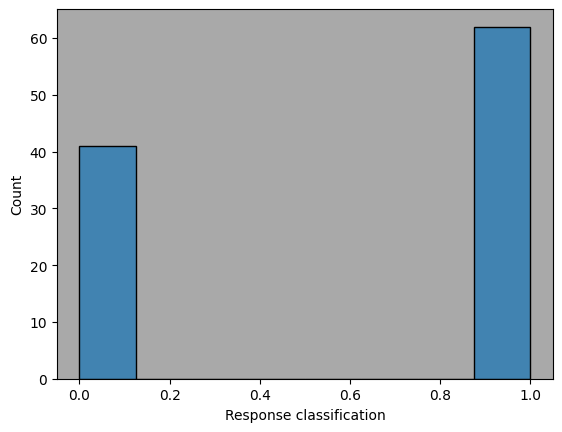

In [7]:
sns.histplot(df['Response classification'])

##### 60-40 split, can continue without removing data. 
##### Keep in mind if our model guesses positive every time it will reach around 60% accuracy. 
##### Also, note that Lebron's record in the finals is 22 wins and 33 losses. Meaning that loss is not indicative of a 'more neutral' tone.

# Begin ML Testing

In [8]:
y = df['Response classification']
x = df[['win', 'loss', 'cumulative wins', 'cumulative losses']]

In [9]:
scaler = StandardScaler()
normalize = Normalizer()

#### Train-test split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=37)

In [11]:
scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_test)

In [12]:
normalize.fit(x_train)
x_train_n = normalize.transform(x_train)
x_test_n = normalize.transform(x_test)

In [13]:
seed = 149
np.random.seed(seed)

50
82


[Text(0.5, 1.0, 'Train Data Distribution')]

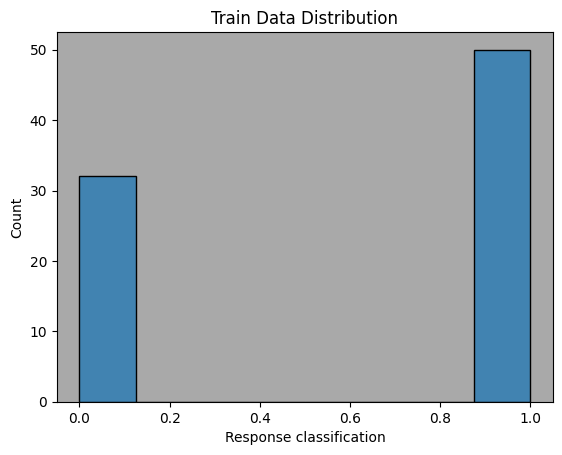

In [14]:
print(y_train.sum())
print(y_train.count())
sns.histplot(y_train).set(title = 'Train Data Distribution')

##### If our models guess positive everytime they would have an accuracy of 60.98% on the training data.

12
21


[Text(0.5, 1.0, 'Test Data Distribution')]

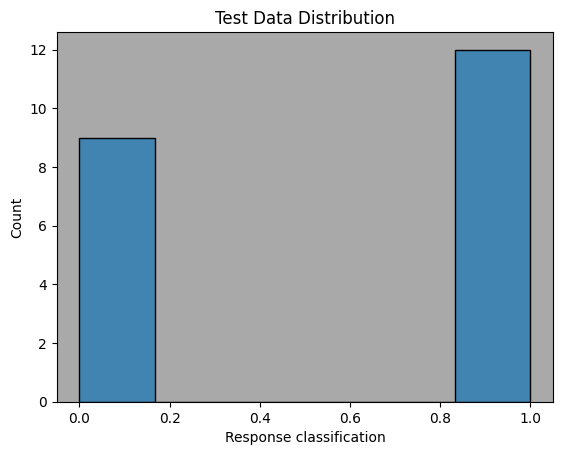

In [15]:
print(y_test.sum())
print(y_test.count())
sns.histplot(y_test).set(title = 'Test Data Distribution')

##### If our models chooses positive everytime they would have an accuracy of 57.14% on the testing data.

### Notice that based on the training data our models are expecting to predict 'more positive' (proportionally) more often than in the testing set. We later look at another random state for our train-test-split which flips this scenario. What we notice is that when models are trained on data with less data points which are categorized as 'more positive' then they are more accurate on the testing data.

# ML Techniques
##### We will use a stratifiedkfold to help reduce the impact of the 40-60 distribution of data on our models

### Gaussian Naive Bayes

In [16]:
gnb = GaussianNB()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(gnb, x_train_s, y_train.values.ravel(), cv=kfold)
gnb_score = cv_score.mean()
print('Gaussian Naive Bayes K-fold Scores:')
print(cv_score)
print()
print('Gaussian Naive Bayes Average Score:')
print(gnb_score)
print()

Gaussian Naive Bayes K-fold Scores:
[0.77777778 0.55555556 0.375      0.875      0.875      0.5
 0.875      0.75       1.         0.875     ]

Gaussian Naive Bayes Average Score:
0.7458333333333333



### Logistic Regression

In [17]:
lr = LogisticRegression(max_iter = 10000)
cv_score = cross_val_score(lr, x_train_s, y_train.values.ravel(), cv=kfold)
lr_score = cv_score.mean()
print('Logistic Regression K-fold Scores (training):')
print(cv_score)
print()
print('Logistic Regression Average Score:')
print(lr_score)

Logistic Regression K-fold Scores (training):
[0.66666667 0.66666667 0.75       0.875      0.875      0.625
 0.875      0.75       0.875      0.875     ]

Logistic Regression Average Score:
0.7833333333333333


### Decision Tree

In [18]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv_score = cross_val_score(dt, x_train_n, y_train.values.ravel(), cv=kfold)
dt_score = cv_score.mean()
print('Decision Tree K-fold Scores:')
print(cv_score)
print()
print('Decision Tree Average Score:')
print(dt_score)

Decision Tree K-fold Scores:
[0.66666667 0.66666667 0.875      0.875      0.875      0.75
 0.75       0.875      0.875      0.625     ]

Decision Tree Average Score:
0.7833333333333333


### KNN

In [19]:
knn = KNeighborsClassifier()
cv_score = cross_val_score(knn, x_train_n, y_train.values.ravel(), cv=kfold)
knn_score = cv_score.mean()
print('KNN K-fold Scores):')
print(cv_score)
print()
print('KNN Average Score:')
print(knn_score)

KNN K-fold Scores):
[0.77777778 0.66666667 0.875      0.875      0.875      0.625
 0.875      0.75       1.         0.75      ]

KNN Average Score:
0.8069444444444445


### Random Forest

In [20]:
rf = RandomForestClassifier(random_state = 1)
cv_score = cross_val_score(rf, x_train, y_train.values.ravel(), cv=kfold)
rf_score = cv_score.mean()
print('Random Forest K-fold Scores:')
print(cv_score)
print()
print('Random Forest Average Score:')
print(rf_score)

Random Forest K-fold Scores:
[0.77777778 0.66666667 0.75       0.875      0.875      0.625
 0.875      0.875      0.875      0.625     ]

Random Forest Average Score:
0.7819444444444444


### Support Vector Classification

In [21]:
svc = SVC(probability = True)
cv_score = cross_val_score(svc, x_train_s, y_train.values.ravel(), cv=kfold)
svc_score = cv_score.mean()
print('Support Vector Classification K-fold Scores:')
print(cv_score)
print()
print('Support Vector Classification Average Score:')
print(svc_score)

Support Vector Classification K-fold Scores:
[0.66666667 0.66666667 0.875      0.875      0.875      0.625
 0.875      0.75       0.875      0.875     ]

Support Vector Classification Average Score:
0.7958333333333333


### XGBoost Classifier

In [22]:
xgb = XGBClassifier(objective='binary:logistic',random_state =1)
cv_score = cross_val_score(xgb, x_train_n, y_train.values.ravel(), cv=kfold)
xgb_score = cv_score.mean()
print('XGBoost Classifier K-fold Scores:')
print(cv_score)
print()
print('XGBoost Classifier Average Score:')
print(xgb_score)

XGBoost Classifier K-fold Scores:
[0.77777778 0.66666667 0.75       0.875      0.875      0.75
 0.875      0.875      1.         0.625     ]

XGBoost Classifier Average Score:
0.8069444444444445


### Neural Network

In [23]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_Train = np_utils.to_categorical(encoded_Y)

In [24]:
def create_model():
    model = Sequential()
    
    model.add(Dense(16, input_dim=x_train_n.shape[1], activation='relu'))
    model.add(Dense(8, activation='relu'))    
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model

In [25]:
model = KerasClassifier(model=create_model, epochs=20, batch_size=2, verbose=0)
##### Had to change batch size to be a factor of total test data points to stop retracing.
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv_score = cross_val_score(model, x_train_n, y_Train, cv=kfold, scoring='accuracy')
nn_score = cv_score.mean()
print('Neural Network K-fold Scores:')
print(cv_score)
print()
print('Neural Network Average Score:')
print(nn_score)

Neural Network K-fold Scores:
[0.88888889 0.66666667 0.5        0.875      1.         0.625
 0.75       0.625      0.5        0.875     ]

Neural Network Average Score:
0.7305555555555555


### Summary of training results

In [26]:
scores = [['Gaussian Naive Bayes', gnb_score],
 ['Logistic Regression', lr_score],
 ['Random Forest', rf_score],
 ['Decision Tree', dt_score],
 ['K-Nearest Neighbor', knn_score],
 ['Support Vector Classifier', svc_score],
 ['XGBoost', xgb_score],
 ['Neural Network', nn_score]]

df_scores = pd.DataFrame(scores,
                         columns = ['Model', 'Accuracy Average']
                        )
df_scores

,Model,Accuracy Average
0,Gaussian Naive Bayes,0.745833
1,Logistic Regression,0.783333
2,Random Forest,0.781944
3,Decision Tree,0.783333
4,K-Nearest Neighbor,0.806944
5,Support Vector Classifier,0.795833
6,XGBoost,0.806944
7,Neural Network,0.730556


### As this is a smaller dataset we will test Logistic regression and SVC. Due to accuracy test we will also test KNN and XGBoost.

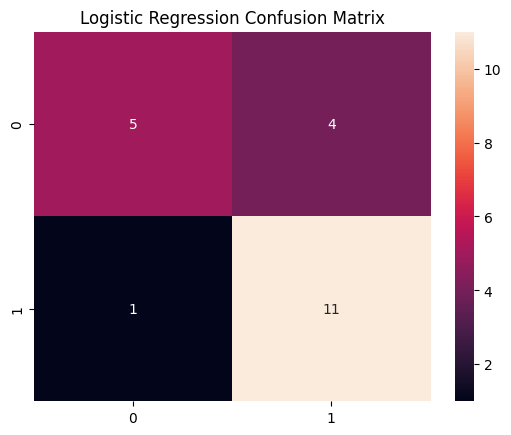

Logistic Regression Model Accuracy (on testing set): 
0.7619047619047619


In [27]:
lr = LogisticRegression(max_iter = 10000)
lr_model = lr.fit(x_train_s, y_train.values.ravel())
y_pred = lr_model.predict(x_test_s)

disp = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
disp.set_title('Logistic Regression Confusion Matrix')
plt.show()

print('Logistic Regression Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

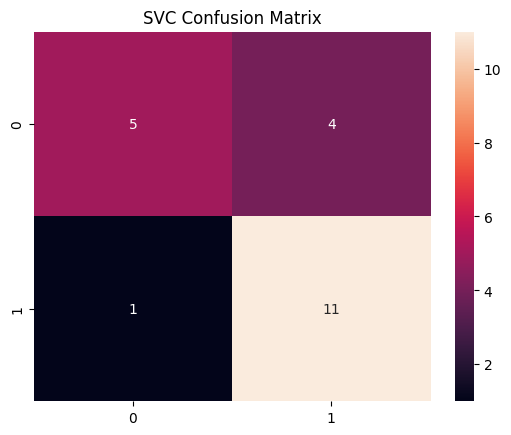

SVC Model Accuracy (on testing set): 
0.7619047619047619


In [28]:
svc = SVC(probability = True)
svc_model = svc.fit(x_train_s, y_train.values.ravel())
y_pred = svc_model.predict(x_test_s)

disp = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
disp.set_title('SVC Confusion Matrix')
plt.show()

print('SVC Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

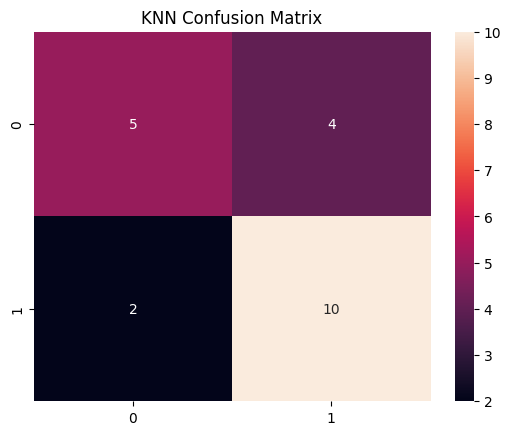

KNN Model Accuracy (on testing set): 
0.7142857142857143


In [29]:
knn = KNeighborsClassifier()
knn_model = knn.fit(x_train_n, y_train.values.ravel())
y_pred = knn_model.predict(x_test_n)

disp = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
disp.set_title('KNN Confusion Matrix')
plt.show()

print('KNN Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

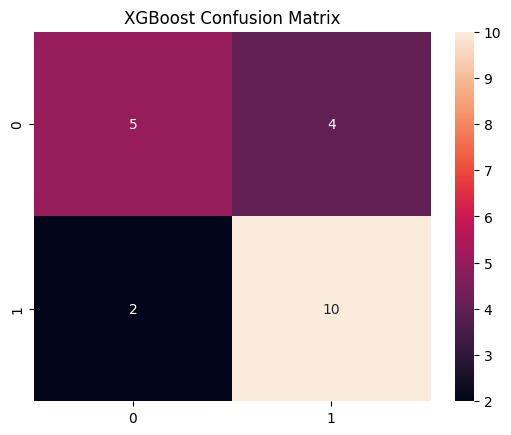

XGBoost Model Accuracy (on testing set): 
0.7142857142857143


In [30]:
xgb = XGBClassifier(objective='binary:logistic',random_state =1)
xgb_model = xgb.fit(x_train_n, y_train.values.ravel())
y_pred = xgb_model.predict(x_test_n)

disp = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
disp.set_title('XGBoost Confusion Matrix')
plt.show()

print('XGBoost Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

# Random_State = 2

### Let's run through the ML methods again with a different random state for our train_test_split

In [31]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=2)

In [32]:
scaler.fit(x_train1)
x_train_s1 = scaler.transform(x_train1)
x_test_s1 = scaler.transform(x_test1)

In [33]:
normalize.fit(x_train1)
x_train_n1 = normalize.transform(x_train1)
x_test_n1 = normalize.transform(x_test1)

48
82


[Text(0.5, 1.0, 'Train Data Distribution')]

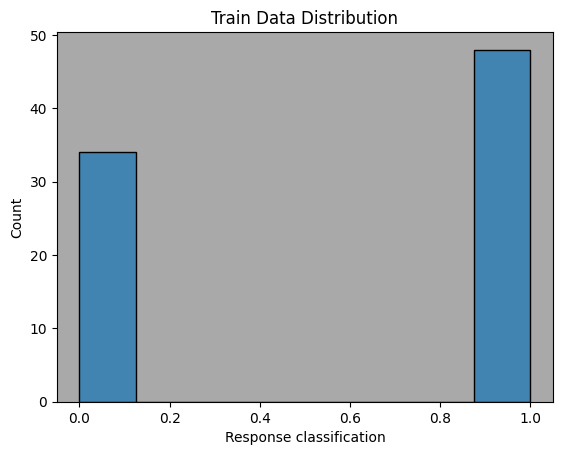

In [34]:
print(y_train1.sum())
print(y_train1.count())
sns.histplot(y_train1).set(title = 'Train Data Distribution')

##### If our models chooses positive everytime they would have an accuracy of 58.54% on the training data.

14
21


[Text(0.5, 1.0, 'Test Data Distribution')]

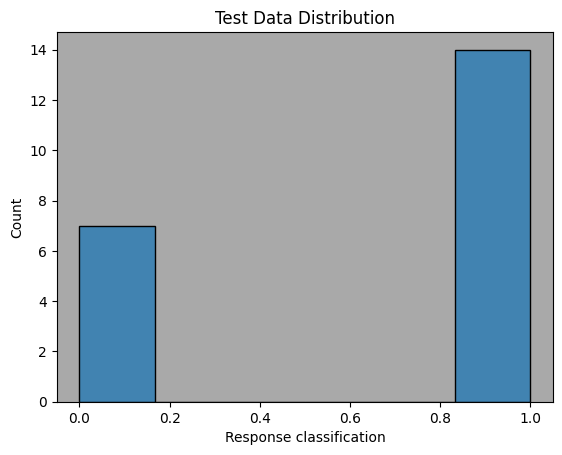

In [35]:
print(y_test1.sum())
print(y_test1.count())
sns.histplot(y_test1).set(title = 'Test Data Distribution')

##### If our models chooses positive everytime they would have an accuracy of 66.67% on the testing data.

### Gaussian Naive Bayes

In [36]:
gnb = GaussianNB()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score1 = cross_val_score(gnb, x_train_s1, y_train1.values.ravel(), cv=kfold)
gnb_score1 = cv_score1.mean()
print('Gaussian Naive Bayes K-fold Scores:')
print(cv_score1)
print()
print('Gaussian Naive Bayes Average Score:')
print(gnb_score1)
print()

Gaussian Naive Bayes K-fold Scores:
[0.88888889 0.77777778 0.875      0.625      0.75       0.75
 0.75       0.875      0.75       0.875     ]

Gaussian Naive Bayes Average Score:
0.7916666666666666



### Logistic Regression

In [37]:
lr = LogisticRegression(max_iter = 10000)
cv_score1 = cross_val_score(lr, x_train_s1, y_train1.values.ravel(), cv=kfold)
lr_score1 = cv_score1.mean()
print('Logistic Regression K-fold Scores (training):')
print(cv_score1)
print()
print('Logistic Regression Average Score:')
print(lr_score1)


Logistic Regression K-fold Scores (training):
[0.66666667 0.77777778 0.875      0.625      0.75       0.75
 0.75       0.75       1.         0.75      ]

Logistic Regression Average Score:
0.7694444444444445


### Decision Tree

In [38]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv_score1 = cross_val_score(dt, x_train_n1, y_train1.values.ravel(), cv=kfold)
dt_score1 = cv_score1.mean()
print('Decision Tree K-fold Scores:')
print(cv_score1)
print()
print('Decision Tree Average Score:')
print(dt_score1)

Decision Tree K-fold Scores:
[0.66666667 0.66666667 0.75       0.625      0.75       0.875
 0.625      0.75       0.625      0.625     ]

Decision Tree Average Score:
0.6958333333333333


### KNN

In [39]:
knn = KNeighborsClassifier()
cv_score1 = cross_val_score(knn, x_train_n1, y_train1.values.ravel(), cv=kfold)
knn_score1 = cv_score1.mean()
print('KNN K-fold Scores):')
print(cv_score1)
print()
print('KNN Average Score:')
print(knn_score1)

KNN K-fold Scores):
[0.88888889 0.77777778 0.75       0.75       0.875      0.75
 0.5        0.625      0.75       0.75      ]

KNN Average Score:
0.7416666666666666


### Random Forest

In [40]:
rf = RandomForestClassifier(random_state = 1)
cv_score1 = cross_val_score(rf, x_train1, y_train1.values.ravel(), cv=kfold)
rf_score1 = cv_score1.mean()
print('Random Forest K-fold Scores:')
print(cv_score1)
print()
print('Random Forest Average Score:')
print(rf_score1)

Random Forest K-fold Scores:
[0.88888889 0.77777778 0.875      0.625      0.75       0.875
 0.5        0.5        0.625      0.75      ]

Random Forest Average Score:
0.7166666666666666


### Support Vector Classification

In [41]:
svc = SVC(probability = True)
cv_score1 = cross_val_score(svc, x_train_s1, y_train1.values.ravel(), cv=kfold)
svc_score1 = cv_score1.mean()
print('Support Vector Classification K-fold Scores:')
print(cv_score1)
print()
print('Support Vector Classification Average Score:')
print(svc_score1)

Support Vector Classification K-fold Scores:
[0.66666667 0.77777778 0.875      0.625      0.75       0.75
 0.75       0.75       0.75       0.875     ]

Support Vector Classification Average Score:
0.7569444444444444


### XGBoost Classifier

In [42]:
xgb = XGBClassifier(objective='binary:logistic',random_state =1)
cv_score1 = cross_val_score(xgb, x_train_n1, y_train1.values.ravel(), cv=kfold)
xgb_score1 = cv_score1.mean()
print('XGBoost Classifier K-fold Scores:')
print(cv_score1)
print()
print('XGBoost Classifier Average Score:')
print(xgb_score1)

XGBoost Classifier K-fold Scores:
[0.88888889 0.77777778 0.875      0.625      0.75       0.875
 0.625      0.75       0.625      0.625     ]

XGBoost Classifier Average Score:
0.7416666666666666


### Neural Network

In [43]:
encoder = LabelEncoder()
encoder.fit(y_train1)
encoded_Y1 = encoder.transform(y_train1)
y_Train1 = np_utils.to_categorical(encoded_Y1)

In [44]:
model = KerasClassifier(model=create_model, epochs=20, batch_size=2, verbose=0)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv_score1 = cross_val_score(model, x_train_n1, y_Train1, cv=kfold, scoring='accuracy')
nn_score1 = cv_score1.mean()
print('Neural Network K-fold Scores:')
print(cv_score1)
print()
print('Neural Network Average Score:')
print(nn_score1)

Neural Network K-fold Scores:
[0.66666667 0.88888889 0.625      0.375      0.75       0.75
 0.5        0.75       0.75       0.75      ]

Neural Network Average Score:
0.6805555555555556


### Summary on training (random state = 2)

In [45]:
scores1 = [['Gaussian Naive Bayes', gnb_score1],
 ['Logistic Regression', lr_score1],
 ['Random Forest', rf_score1],
 ['Decision Tree', dt_score1],
 ['K-Nearest Neighbor', knn_score1],
 ['Support Vector Classifier', svc_score1],
 ['XGBoost', xgb_score1],
 ['Neural Network', nn_score1]]

df_scores1 = pd.DataFrame(scores1,
                         columns = ['Model', 'Accuracy Average']
                        )
df_scores1

,Model,Accuracy Average
0,Gaussian Naive Bayes,0.791667
1,Logistic Regression,0.769444
2,Random Forest,0.716667
3,Decision Tree,0.695833
4,K-Nearest Neighbor,0.741667
5,Support Vector Classifier,0.756944
6,XGBoost,0.741667
7,Neural Network,0.680556


### Lets use all of our ML techniques (except NN) to make predictions on the test data and find their best results using different scaler options.

In [46]:
models = {}

# Naive Bayes
models['Naive Bayes'] = GaussianNB()

# Logistic Regression
models['Logistic Regression'] = LogisticRegression(max_iter = 10000)

# Random Forest
models['Random Forest'] = RandomForestClassifier(random_state = 1)

# Decision Trees
models['Decision Trees'] = tree.DecisionTreeClassifier(random_state = 1)

# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()

# Support Vector Machines
models['Support Vector Machines'] = SVC(probability = True)

# XGboost (gradient descent)
models['XGBoost'] = XGBClassifier(objective='binary:logistic',random_state =1)

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(x_train1, y_train1)
    
    # Make predictions
    predictions = models[key].predict(x_test1)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test1)
    precision[key] = precision_score(predictions, y_test1)
    recall[key] = recall_score(predictions, y_test1)

#### No scaler is applied to the data

In [48]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Naive Bayes,0.714286,0.714286,0.833333
Logistic Regression,0.761905,0.785714,0.846154
Random Forest,0.666667,0.642857,0.818182
Decision Trees,0.666667,0.642857,0.818182
K-Nearest Neighbor,0.666667,0.642857,0.818182
Support Vector Machines,0.761905,0.785714,0.846154
XGBoost,0.714286,0.714286,0.833333


#### The StandardScaler() is applied to the data

In [49]:
accuracy_s, precision_s, recall_s = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(x_train_s1, y_train1)
    
    # Make predictions
    predictions_s = models[key].predict(x_test_s1)
    
    # Calculate metrics
    accuracy_s[key] = accuracy_score(predictions_s, y_test1)
    precision_s[key] = precision_score(predictions_s, y_test1)
    recall_s[key] = recall_score(predictions_s, y_test1)

In [50]:
df_model_s = pd.DataFrame(index=models.keys(), columns=['Accuracy_s', 'Precision_s', 'Recall_s'])
df_model_s['Accuracy_s'] = accuracy_s.values()
df_model_s['Precision_s'] = precision_s.values()
df_model_s['Recall_s'] = recall_s.values()

df_model_s

,Accuracy_s,Precision_s,Recall_s
Naive Bayes,0.714286,0.714286,0.833333
Logistic Regression,0.809524,0.857143,0.857143
Random Forest,0.666667,0.642857,0.818182
Decision Trees,0.666667,0.642857,0.818182
K-Nearest Neighbor,0.619048,0.500000,0.875000
Support Vector Machines,0.714286,0.714286,0.833333
XGBoost,0.714286,0.714286,0.833333


#### The Normalizer() scaler is applied to the data

In [51]:
accuracy_n, precision_n, recall_n = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(x_train_n1, y_train1)
    
    # Make predictions
    predictions_n = models[key].predict(x_test_n1)
    
    # Calculate metrics
    accuracy_n[key] = accuracy_score(predictions_n, y_test1)
    precision_n[key] = precision_score(predictions_n, y_test1)
    recall_n[key] = recall_score(predictions_n, y_test1)

In [52]:
df_model_n = pd.DataFrame(index=models.keys(), columns=['Accuracy_n', 'Precision_n', 'Recall_n'])
df_model_n['Accuracy_n'] = accuracy_n.values()
df_model_n['Precision_n'] = precision_n.values()
df_model_n['Recall_n'] = recall_n.values()

df_model_n

,Accuracy_n,Precision_n,Recall_n
Naive Bayes,0.666667,0.571429,0.888889
Logistic Regression,0.619048,0.571429,0.800000
Random Forest,0.761905,0.785714,0.846154
Decision Trees,0.761905,0.785714,0.846154
K-Nearest Neighbor,0.809524,0.857143,0.857143
Support Vector Machines,0.666667,0.571429,0.888889
XGBoost,0.761905,0.785714,0.846154


#### Combine all results into one df

In [53]:
df_model_all = pd.concat([df_model, df_model_s, df_model_n], axis=1)
df_model_all

,Accuracy,Precision,Recall,Accuracy_s,Precision_s,Recall_s,Accuracy_n,Precision_n,Recall_n
Naive Bayes,0.714286,0.714286,0.833333,0.714286,0.714286,0.833333,0.666667,0.571429,0.888889
Logistic Regression,0.761905,0.785714,0.846154,0.809524,0.857143,0.857143,0.619048,0.571429,0.800000
Random Forest,0.666667,0.642857,0.818182,0.666667,0.642857,0.818182,0.761905,0.785714,0.846154
Decision Trees,0.666667,0.642857,0.818182,0.666667,0.642857,0.818182,0.761905,0.785714,0.846154
K-Nearest Neighbor,0.666667,0.642857,0.818182,0.619048,0.500000,0.875000,0.809524,0.857143,0.857143
Support Vector Machines,0.761905,0.785714,0.846154,0.714286,0.714286,0.833333,0.666667,0.571429,0.888889
XGBoost,0.714286,0.714286,0.833333,0.714286,0.714286,0.833333,0.761905,0.785714,0.846154


In [54]:
df_model_all['max_acc'] = df_model_all[['Accuracy', 'Accuracy_s', 'Accuracy_n']].max(axis=1)
df_model_all['max_prec'] = df_model_all[['Precision', 'Precision_s', 'Precision_n']].max(axis=1)
df_model_all['max_recal'] = df_model_all[['Recall', 'Recall_s', 'Recall_n']].max(axis=1)
df_model_all

,Accuracy,Precision,Recall,Accuracy_s,Precision_s,Recall_s,Accuracy_n,Precision_n,Recall_n,max_acc,max_prec,max_recal
Naive Bayes,0.714286,0.714286,0.833333,0.714286,0.714286,0.833333,0.666667,0.571429,0.888889,0.714286,0.714286,0.888889
Logistic Regression,0.761905,0.785714,0.846154,0.809524,0.857143,0.857143,0.619048,0.571429,0.800000,0.809524,0.857143,0.857143
Random Forest,0.666667,0.642857,0.818182,0.666667,0.642857,0.818182,0.761905,0.785714,0.846154,0.761905,0.785714,0.846154
Decision Trees,0.666667,0.642857,0.818182,0.666667,0.642857,0.818182,0.761905,0.785714,0.846154,0.761905,0.785714,0.846154
K-Nearest Neighbor,0.666667,0.642857,0.818182,0.619048,0.500000,0.875000,0.809524,0.857143,0.857143,0.809524,0.857143,0.875000
Support Vector Machines,0.761905,0.785714,0.846154,0.714286,0.714286,0.833333,0.666667,0.571429,0.888889,0.761905,0.785714,0.888889
XGBoost,0.714286,0.714286,0.833333,0.714286,0.714286,0.833333,0.761905,0.785714,0.846154,0.761905,0.785714,0.846154


### Identify metrics from best performing scaler

In [55]:
df_bestmodels = pd.DataFrame(index=models.keys(), columns = ['Accuracy','Precision','Recall'])
df_bestmodels['Accuracy'] = df_model_all['max_acc']
df_bestmodels['Precision'] = df_model_all['max_prec']
df_bestmodels['Recall'] = [0.833333, 0.857143, 0.846154, 0.846154, 0.857143, 0.846154, 0.846154] 

df_bestmodels

,Accuracy,Precision,Recall
Naive Bayes,0.714286,0.714286,0.833333
Logistic Regression,0.809524,0.857143,0.857143
Random Forest,0.761905,0.785714,0.846154
Decision Trees,0.761905,0.785714,0.846154
K-Nearest Neighbor,0.809524,0.857143,0.857143
Support Vector Machines,0.761905,0.785714,0.846154
XGBoost,0.761905,0.785714,0.846154


In [56]:
plt.style.use('seaborn-v0_8-deep')

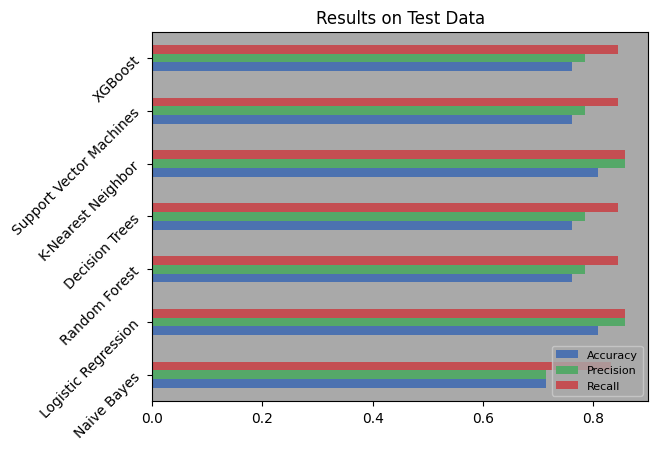

In [57]:
ax = df_bestmodels.plot.barh()
ax.set(title = 'Results on Test Data')
labels = ax.get_yticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.legend(  
    loc='lower right', 
    prop={'size': 8}
)

### Let's take a closer look at the results on some of our better performing models.

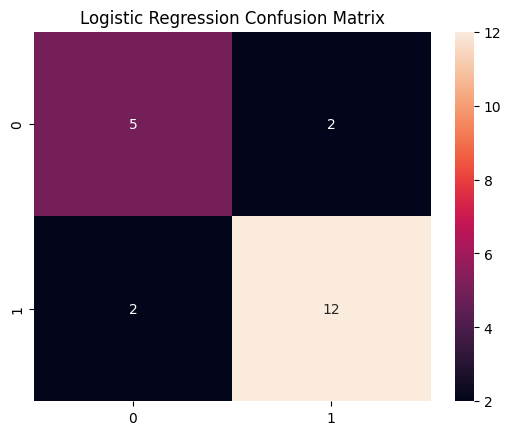

Logistic Regression Model Accuracy (on testing set): 
0.8095238095238095


In [58]:
lr = LogisticRegression(max_iter = 10000)
lr_model = lr.fit(x_train_s1, y_train1.values.ravel())
y_pred1 = lr_model.predict(x_test_s1)

disp = sns.heatmap(confusion_matrix(y_test1, y_pred1), annot=True)
disp.set_title('Logistic Regression Confusion Matrix')
plt.show()

print('Logistic Regression Model Accuracy (on testing set): ')
print(accuracy_score(y_test1, y_pred1))

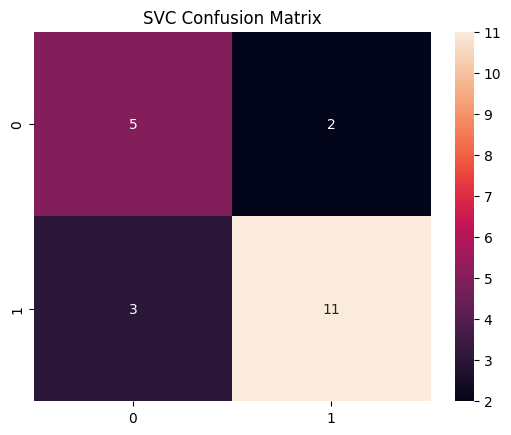

SVC Model Accuracy (on testing set): 
0.7619047619047619


In [59]:
svc = SVC(probability = True)
svc_model = svc.fit(x_train1, y_train1.values.ravel())
y_pred1 = svc_model.predict(x_test1)

disp = sns.heatmap(confusion_matrix(y_test1, y_pred1), annot=True)
disp.set_title('SVC Confusion Matrix')
plt.show()

print('SVC Model Accuracy (on testing set): ')
print(accuracy_score(y_test1, y_pred1))

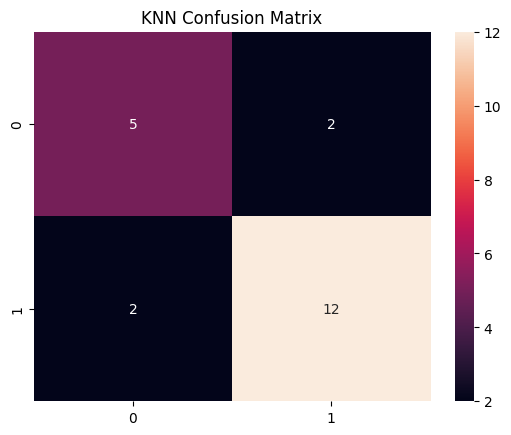

KNN Model Accuracy (on testing set): 
0.8095238095238095


In [60]:
knn = KNeighborsClassifier()
knn_model = knn.fit(x_train_n1, y_train1.values.ravel())
y_pred1 = knn_model.predict(x_test_n1)

disp = sns.heatmap(confusion_matrix(y_test1, y_pred1), annot=True)
disp.set_title('KNN Confusion Matrix')
plt.show()

print('KNN Model Accuracy (on testing set): ')
print(accuracy_score(y_test1, y_pred1))

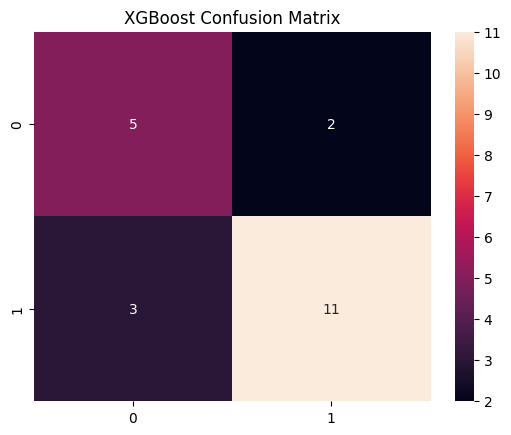

XGBoost Model Accuracy (on testing set): 
0.7619047619047619


In [61]:
xgb = XGBClassifier(objective='binary:logistic',random_state =1)
xgb_model = xgb.fit(x_train_n1, y_train1.values.ravel())
y_pred1 = xgb_model.predict(x_test_n1)

disp = sns.heatmap(confusion_matrix(y_test1, y_pred1), annot=True)
disp.set_title('XGBoost Confusion Matrix')
plt.show()

print('XGBoost Model Accuracy (on testing set): ')
print(accuracy_score(y_test1, y_pred1))

# Conclusion

##### We converted our quantitative variable, 'Response Rating', to a categorical varaible by splitting the data into two groups. Now our data is ready for binary classification. With our data set on the smaller size we identify logistic regression (LR) and SVC as viable methods. We test eight different binary classification methods to identify the best performing. SVC, LR, and KNN were regularly our top performing techniques. When evaluating results on different random states (for test-train-split) we identified a trend between test data which had larger amounts of 'more positive' data points and better the accuracy on the test data set.  Ultimatively, we saw accuracy ranging from 70% up to 90%+ on the train and test data. For our selected random state, we obtained 80.95% accuracy using our LR and KNN models and 76.19% accuracy using the SVC model on our test data. These values are in excess of 25% more accurate than choosing 'more positive' every time and given our limitations on features (due to practice interviews having no associated statistics unlike post-game interviews) we find these results to be fairly strong.